# Metadata Analysis and Coffee Group Definition

This notebook focuses on detailed metadata analysis and establishing clear coffee consumption groups for the main microbiome analysis.

## Objectives:
- Refine coffee consumption group definitions
- Validate group characteristics and sample sizes
- Create final metadata subset for diversity analysis
- Export clean datasets for downstream analysis

## Analysis Flow:

### 1. **Data Loading & Initial Setup**
- Load cleaned data from notebook 01
- Import required libraries for statistical analysis
- Set up visualization parameters

### 2. **Coffee Group Refinement**
- **Current categories**: Review 'None', 'Occasional', 'Daily' groups from EDA
- **Group validation**: Assess if current groupings are optimal for analysis
- **Sample size considerations**: Ensure adequate power for statistical tests
- **Alternative groupings**: Consider binary (Coffee vs No Coffee) if needed

### 3. **Quality Control and Filtering**
- **Missing data assessment**: Identify and handle any missing values in key variables
- **Outlier detection**: Screen for extreme values in age/BMI that might affect analysis
- **Sample exclusions**: Document any samples removed and reasons
- **Final sample sizes**: Report final group sizes for main analysis

### 4. **Metadata Export and Summary**
- **Clean metadata export**: Save processed metadata for diversity analysis
- **Group definitions**: Create clear coffee group variable for analysis
- **Summary statistics**: Final demographic table by coffee consumption
- **Data validation**: Confirm alignment between metadata, feature table, and taxonomy

## Expected Outcomes:
- **Clear coffee groups**: Well-defined categories with adequate sample sizes
- **Validated demographics**: Confirmed minimal confounding across groups
- **Clean datasets**: Quality-controlled data ready for microbiome diversity analysis
- **Documentation**: Clear record of data processing decisions for reproducibility

## 1. Import Libraries and Load Data

In [1]:
# Import data manipulation libraries
import polars as pl
import numpy as np
import pandas as pd
import pyarrow as pa

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import statistical libraries
import scipy.stats as stats # for ANOVA, chi-square tests, effect size calculations
from sklearn import preprocessing
from cohens_d import cohens_d as cohens_d_func

# Import utility libraries
from pathlib import Path
import warnings

# Set up visualization parameters
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (10, 6)  # Set default figure size
sns.set_palette("Set2")  # Set default color palette

# Configure display options
pl.Config.set_fmt_str_lengths(100)  # Limit string length in polars output
pl.Config.set_tbl_rows(10)  # Limit number of rows displayed in polars
np.set_printoptions(precision=3, suppress=True)  # Set numpy print options
pd.set_option('display.max_rows', 10)  # Limit number of rows displayed inpandas
pd.set_option('display.max_colwidth', 100)  # Limit column width

# Print confirmation that libraries loaded successfully
print("All libraries imported and configured successfully!")

All libraries imported and configured successfully!


## 2. Coffee Group Definition and Validation

### 2.1 Current Coffee Categories Review

In [2]:
# Load the processed datasets
metadata_path = Path("../data/raw/metadata.tsv")
feature_table_path = Path("../data/raw/feature-table.tsv")
taxonomy_path = Path("../data/raw/taxonomy.tsv")

metadata = pl.read_csv(metadata_path, separator='\t')
feature_table = pl.read_csv(feature_table_path, separator='\t')
taxonomy = pl.read_csv(taxonomy_path, separator='\t')

In [3]:
metadata.head(n=2)

#SampleID,age,gender,country,sample_type,diet_type,coffee_consumption,antibiotics_past_year,bmi
str,i64,str,str,str,str,str,str,i64
"""Sample_00000""",56,"""male""","""Australia""","""Stool""","""Omnivore""","""daily""","""Yes""",18
"""Sample_00001""",69,"""female""","""Australia""","""Stool""","""Omnivore""","""daily""","""No""",27


Coffee Consumption Value Counts:
shape: (3, 2)
┌────────────────────┬───────┐
│ coffee_consumption ┆ count │
│ ---                ┆ ---   │
│ str                ┆ u32   │
╞════════════════════╪═══════╡
│ daily              ┆ 1685  │
│ none               ┆ 1628  │
│ occasional         ┆ 1687  │
└────────────────────┴───────┘


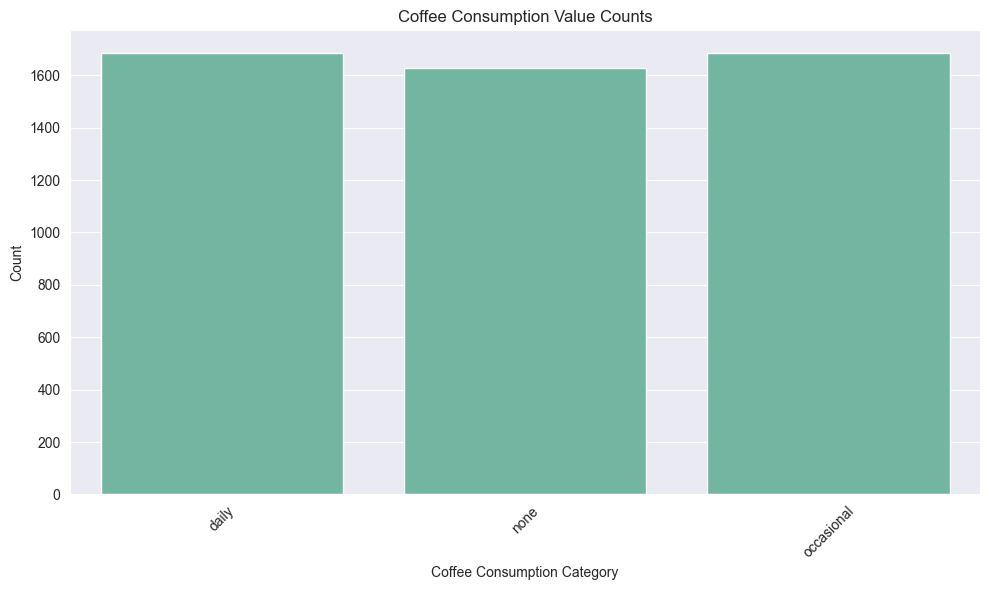

In [4]:
# Quick review of current coffee categories

# Display coffee consumption value counts
coffee_counts = metadata['coffee_consumption'].value_counts()
print("Coffee Consumption Value Counts:")
print(coffee_counts)

# display as bar plot
sns.barplot(x=coffee_counts['coffee_consumption'], y=coffee_counts['count'])
plt.title("Coffee Consumption Value Counts")
plt.xlabel("Coffee Consumption Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Manual Cohen's d calculation function
def calculate_cohens_d(group1, group2):
    """Calculate Cohen's d effect size between two groups"""
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    
    # Cohen's d
    d = (mean1 - mean2) / pooled_std
    return d

In [6]:
# Pseudo-code for validation:
# 1. Calculate effect sizes between all pairs:
#    - None vs Occasional  
#    - Occasional vs Daily
#    - None vs Daily
# 2. Expect: None vs Daily > Occasional vs Daily > None vs Occasional
# 3. If effect sizes are meaningful (d>0.2), keep 3 groups
# 4. If Occasional is identical to one extreme, then consider combining

# separate metadata into groups based on coffee consumption
drinkers_none = metadata.filter(metadata['coffee_consumption']=='none')
drinkers_occasional = metadata.filter(metadata['coffee_consumption']=='occasional')
drinkers_daily = metadata.filter(metadata['coffee_consumption']=='daily')

# Extract age data for effect size calculations
age_none = drinkers_none['age'].to_numpy()
age_occasional = drinkers_occasional['age'].to_numpy()
age_daily = drinkers_daily['age'].to_numpy()

# extract bmi data
bmi_none = drinkers_none['bmi'].to_numpy()
bmi_occasional = drinkers_occasional['bmi'].to_numpy()
bmi_daily = drinkers_daily['bmi'].to_numpy()

# effect size calculation function with cohens_d
effect_age_none_vs_occasional = calculate_cohens_d(age_none, age_occasional)
effect_age_occasional_vs_daily = calculate_cohens_d(age_occasional, age_daily)
effect_age_none_vs_daily = calculate_cohens_d(age_none, age_daily)

# effect size calculation for bmi
effect_bmi_none_vs_occasional = calculate_cohens_d(bmi_none, bmi_occasional)
effect_bmi_occasional_vs_daily = calculate_cohens_d(bmi_occasional, bmi_daily)
effect_bmi_none_vs_daily = calculate_cohens_d(bmi_none, bmi_daily)

# print effect sizes
print(f"Cohen's d for Age - None vs Occasional: {effect_age_none_vs_occasional:.3f}")
print(f"Cohen's d for Age - Occasional vs Daily: {effect_age_occasional_vs_daily:.3f}")
print(f"Cohen's d for Age - None vs Daily: {effect_age_none_vs_daily:.3f}")
print("\n")
print(f"Cohen's d for BMI - None vs Occasional: {effect_bmi_none_vs_occasional:.3f}")
print(f"Cohen's d for BMI - Occasional vs Daily: {effect_bmi_occasional_vs_daily:.3f}")
print(f"Cohen's d for BMI - None vs Daily: {effect_bmi_none_vs_daily:.3f}")

Cohen's d for Age - None vs Occasional: -0.050
Cohen's d for Age - Occasional vs Daily: 0.015
Cohen's d for Age - None vs Daily: -0.036


Cohen's d for BMI - None vs Occasional: 0.017
Cohen's d for BMI - Occasional vs Daily: -0.016
Cohen's d for BMI - None vs Daily: 0.001


In [7]:
def plot_contingency_heatmap_polars(data, var1, var2, figsize=(8, 6)):
    """
    Create a heatmap of contingency table between two categorical variables
    Using only Polars (no pandas)
    
    Parameters:
    -----------
    data : polars.DataFrame
        The metadata dataframe
    var1 : str
        First variable name (will be rows)
    var2 : str
        Second variable name (will be columns)
    figsize : tuple
        Figure size for the plot
    """
    
    # Create contingency table using Polars
    contingency_pl = (data
                     .group_by([var1, var2])
                     .agg(pl.len().alias('count'))
                     .pivot(values='count', index=var1, columns=var2, aggregate_function='first')
                     .fill_null(0)
                     .sort(var1))
    
    # Extract row and column names
    row_names = contingency_pl[var1].to_list()
    col_names = [col for col in contingency_pl.columns if col != var1]
    
    # Extract the count matrix as numpy array
    count_matrix = contingency_pl.select(col_names).to_numpy()
    
    # Calculate chi-square manually since we can't use pandas crosstab
    # Expected frequencies calculation
    row_totals = count_matrix.sum(axis=1)
    col_totals = count_matrix.sum(axis=0)
    total = count_matrix.sum()
    
    expected = np.outer(row_totals, col_totals) / total
    
    # Chi-square calculation
    chi2 = np.sum((count_matrix - expected)**2 / expected)
    
    # Degrees of freedom
    dof = (len(row_names) - 1) * (len(col_names) - 1)
    
    # P-value using chi2 distribution
    from scipy.stats import chi2 as chi2_dist
    p_val = 1 - chi2_dist.cdf(chi2, dof)
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    
    # Plot heatmap with annotations
    sns.heatmap(count_matrix,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=col_names,
                yticklabels=row_names,
                cbar_kws={'label': 'Count'},
                linewidths=0.5)
    
    # Customize the plot
    plt.title(f'Contingency Table: {var1.title()} vs {var2.title()}\n' +
              f'χ² = {chi2:.3f}, p-value = {p_val:.3f}', 
              fontsize=14, pad=20)
    plt.xlabel(var2.replace('_', ' ').title(), fontsize=12)
    plt.ylabel(var1.replace('_', ' ').title(), fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Print the contingency table nicely
    print("Contingency Table:")
    print(f"\n{var1} \\ {var2}".ljust(15), end="")
    for col in col_names:
        print(f"{col:>8}", end="")
    print(f"{'Total':>8}")
    print("-" * (15 + 8 * (len(col_names) + 1)))
    
    for i, row in enumerate(row_names):
        print(f"{row}".ljust(15), end="")
        row_total = 0
        for j, count in enumerate(count_matrix[i]):
            print(f"{int(count):>8}", end="")
            row_total += count
        print(f"{int(row_total):>8}")
    
    # Print column totals
    print("-" * (15 + 8 * (len(col_names) + 1)))
    print("Total".ljust(15), end="")
    grand_total = 0
    for j in range(len(col_names)):
        col_total = count_matrix[:, j].sum()
        print(f"{int(col_total):>8}", end="")
        grand_total += col_total
    print(f"{int(grand_total):>8}")
    
    print(f"\nChi-square test: χ² = {chi2:.3f}, p-value = {p_val:.3f}")
    print(f"Degrees of freedom: {dof}")
    
    return contingency_pl, chi2, p_val

# Example usage:
# contingency_table, chi2, p_val = plot_contingency_heatmap_polars(metadata, 'gender', 'coffee_consumption')

/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_40839/1627086628.py:18: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  contingency_pl = (metadata
/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_40839/1627086628.py:18: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  contingency_pl = (metadata
/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_40839/1627086628.py:18: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  contingency_pl = (metadata
/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_40839/1627086628.py:18: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  contingency_pl = (metadata


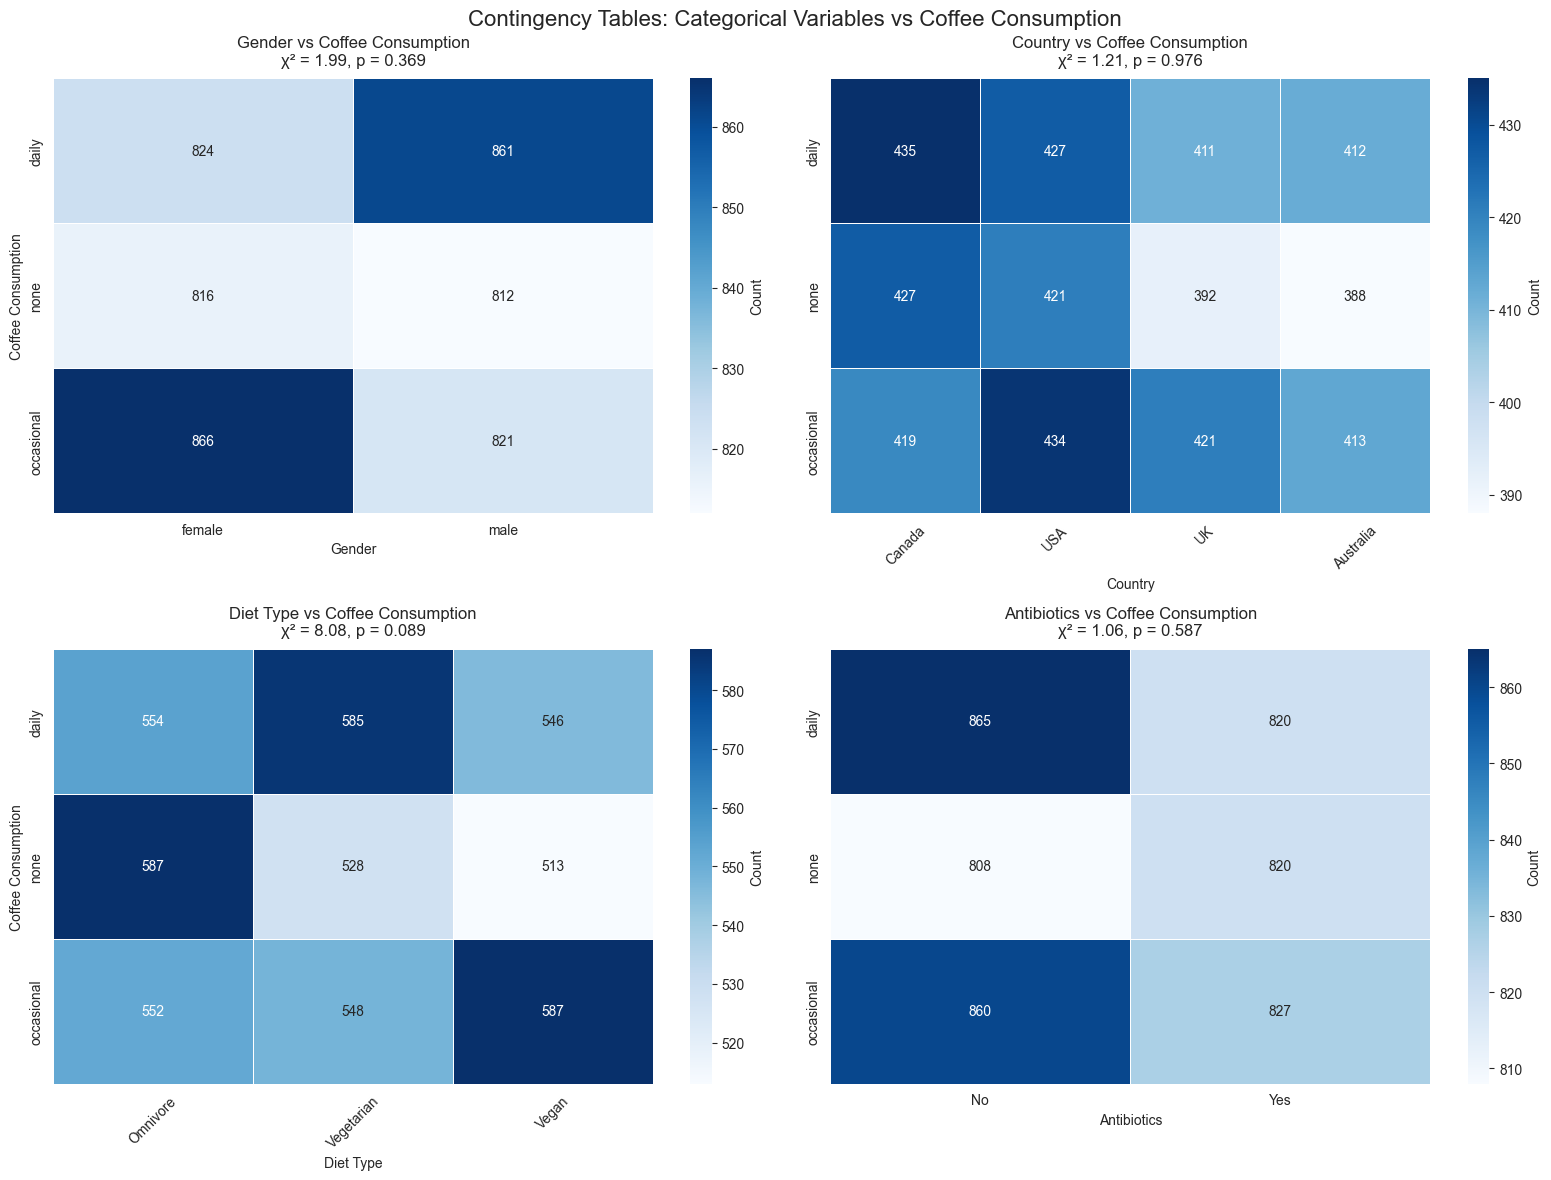

SUMMARY: Chi-square Tests for Categorical Variables
Variable                  Chi2     p-value    Significant 
------------------------------------------------------------
gender                    1.99     0.369      No          
country                   1.21     0.976      No          
diet_type                 8.08     0.089      No          
antibiotics_past_year     1.06     0.587      No          

Interpretation:
- p < 0.05: Significant association between variable and coffee consumption
- p >= 0.05: No significant association (variables are independent)


In [8]:
# Create a 2x2 grid of contingency heatmaps for categorical variables
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Contingency Tables: Categorical Variables vs Coffee Consumption', fontsize=16, y=0.98)

# List of variables to plot
categorical_vars = ['gender', 'country', 'diet_type', 'antibiotics_past_year']
var_titles = ['Gender', 'Country', 'Diet Type', 'Antibiotics']

# Storage for chi-square results
chi2_results = {}

# Loop through each variable and create subplot
for idx, (var, title) in enumerate(zip(categorical_vars, var_titles)):
    row = idx // 2  # 0 or 1
    col = idx % 2   # 0 or 1
    
    # Create contingency table using Polars
    contingency_pl = (metadata
                     .group_by(['coffee_consumption', var])
                     .agg(pl.len().alias('count'))
                     .pivot(values='count', index='coffee_consumption', columns=var, aggregate_function='first')
                     .fill_null(0)
                     .sort('coffee_consumption'))
    
    # Extract data for heatmap
    row_names = contingency_pl['coffee_consumption'].to_list()
    col_names = [col for col in contingency_pl.columns if col != 'coffee_consumption']
    count_matrix = contingency_pl.select(col_names).to_numpy()
    
    # Calculate chi-square
    row_totals = count_matrix.sum(axis=1)
    col_totals = count_matrix.sum(axis=0)
    total = count_matrix.sum()
    expected = np.outer(row_totals, col_totals) / total
    chi2 = np.sum((count_matrix - expected)**2 / expected)
    dof = (len(row_names) - 1) * (len(col_names) - 1)
    from scipy.stats import chi2 as chi2_dist
    p_val = 1 - chi2_dist.cdf(chi2, dof)
    
    # Store results
    chi2_results[var] = {'chi2': chi2, 'p_val': p_val, 'dof': dof}
    
    # Create heatmap on subplot
    sns.heatmap(count_matrix,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=col_names,
                yticklabels=row_names,
                cbar_kws={'label': 'Count'},
                linewidths=0.5,
                ax=axes[row, col])
    
    # Customize subplot
    axes[row, col].set_title(f'{title} vs Coffee Consumption\nχ² = {chi2:.2f}, p = {p_val:.3f}', 
                            fontsize=12, pad=10)
    axes[row, col].set_xlabel(title, fontsize=10)
    axes[row, col].set_ylabel('Coffee Consumption' if col == 0 else '', fontsize=10)
    
    # Rotate x-axis labels if they're long
    if var in ['diet_type', 'country']:
        axes[row, col].tick_params(axis='x', rotation=45)
    else:
        axes[row, col].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Print summary of chi-square results
print("=" * 60)
print("SUMMARY: Chi-square Tests for Categorical Variables")
print("=" * 60)
print(f"{'Variable':<25} {'Chi2':<8} {'p-value':<10} {'Significant':<12}")
print("-" * 60)

for var, results in chi2_results.items():
    significant = "Yes" if results['p_val'] < 0.05 else "No"
    print(f"{var:<25} {results['chi2']:<8.2f} {results['p_val']:<10.3f} {significant:<12}")

print("\nInterpretation:")
print("- p < 0.05: Significant association between variable and coffee consumption")
print("- p >= 0.05: No significant association (variables are independent)")

## Effect Size Analysis Summary

All pairwise comparisons between coffee consumption groups (None, Occasional, Daily) showed negligible effect sizes (|d| < 0.2) for both age and BMI, indicating no meaningful demographic differences. All categorical variables (gender, country, diet type, antibiotics) showed non-significant associations with coffee consumption (all p > 0.05), confirming independence between demographics and coffee groups.


**Key Findings:**
- ✅ **Age is well-balanced** across coffee groups - no confounding concern
- ✅ **BMI is well-balanced** across coffee groups - no confounding concern  
- ✅ **All categorical variables independent** of coffee consumption - no confounding
- ✅ **Coffee groups are demographically similar** - ideal for microbiome analysis

### **Decision:**
**Proceed with 3-group analysis** (None, Occasional, Daily) without demographic adjustment. The minimal effect sizes and non-significant associations confirm that observed microbiome differences will likely reflect coffee consumption rather than demographic confounders.

---
**Reference:** Cohen's d interpretation: |d| < 0.2 = negligible, 0.2-0.5 = small, 0.5-0.8 = medium, >0.8 = large effect size.

### 2.2 Sample Size Assessment and Group Optimization

In [9]:
# calculate group percentages
total_samples = len(metadata)

print("Group Percentages")

for each_group in coffee_counts['coffee_consumption']:
    n = coffee_counts.filter(pl.col('coffee_consumption')==each_group)['count'].to_list()[0]
    percentage = (n/total_samples) 
    print("{:15} : {:.2%}".format(each_group, percentage))

Group Percentages
daily           : 33.70%
none            : 32.56%
occasional      : 33.74%


Based on the sample size assessment, the coffee consumption groups are well-balanced with each representing approximately 33% of the total sample. 

**Sample Distribution:**
- Groups are evenly distributed (~33% each)
- No extreme imbalances that could bias results
- Sample sizes provide robust statistical power for all planned analyses

**Final Group Assignment Decision:**
✅ **Maintain 3-group structure** (None, Occasional, Daily) for optimal biological interpretability and statistical rigor.

### 3.1 Age and BMI Across Coffee Groups

### 3.2 Categorical Variables by Coffee Consumption

### 3.3 Statistical Testing and Effect Size Analysis

## 3. Data Quality Control

### 3.1 Missing Data Assessment

In [10]:
# Display null counts for all columns (without truncation)
null_count = metadata.null_count()

# Convert to long format to see all columns
null_summary = (null_count
                .transpose(include_header=True)
                .rename({'column': 'variable', 'column_0': 'null_count'}))

print("Missing Data Summary - All Variables:")
print("=" * 40)
print(null_summary)

# Quick summary of missing data
total_nulls = null_summary['null_count'].sum()
total_possible = metadata.shape[0] * metadata.shape[1] 
missing_percentage = (total_nulls / total_possible) * 100

print(f"\nOverall Missing Data Summary:")
print(f"Total null values: {total_nulls:,}")
print(f"Total possible values: {total_possible:,}")
print(f"Overall missing rate: {missing_percentage:.2f}%")

Missing Data Summary - All Variables:
shape: (9, 2)
┌───────────────────────┬────────────┐
│ variable              ┆ null_count │
│ ---                   ┆ ---        │
│ str                   ┆ u32        │
╞═══════════════════════╪════════════╡
│ #SampleID             ┆ 0          │
│ age                   ┆ 0          │
│ gender                ┆ 0          │
│ country               ┆ 0          │
│ sample_type           ┆ 0          │
│ diet_type             ┆ 0          │
│ coffee_consumption    ┆ 0          │
│ antibiotics_past_year ┆ 0          │
│ bmi                   ┆ 0          │
└───────────────────────┴────────────┘

Overall Missing Data Summary:
Total null values: 0
Total possible values: 45,000
Overall missing rate: 0.00%


**Missing Data Assessment Results:**

✅ **No missing data detected** - All variables have complete information across all samples.

With no missing values in the dataset, we can proceed directly to outlier detection without any data imputation or sample exclusion due to missingness. This complete dataset ensures robust statistical analyses without concerns about bias from missing data patterns.

### 3.2 Outlier Detection and Handling

In [11]:
# z-score distributions
metadata = metadata.with_columns(
    age_zscore = (pl.col('age') - pl.col('age').mean()) / pl.col('age').std(),
    bmi_zscore = (pl.col('bmi') - pl.col('bmi').mean()) / pl.col('bmi').std()
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


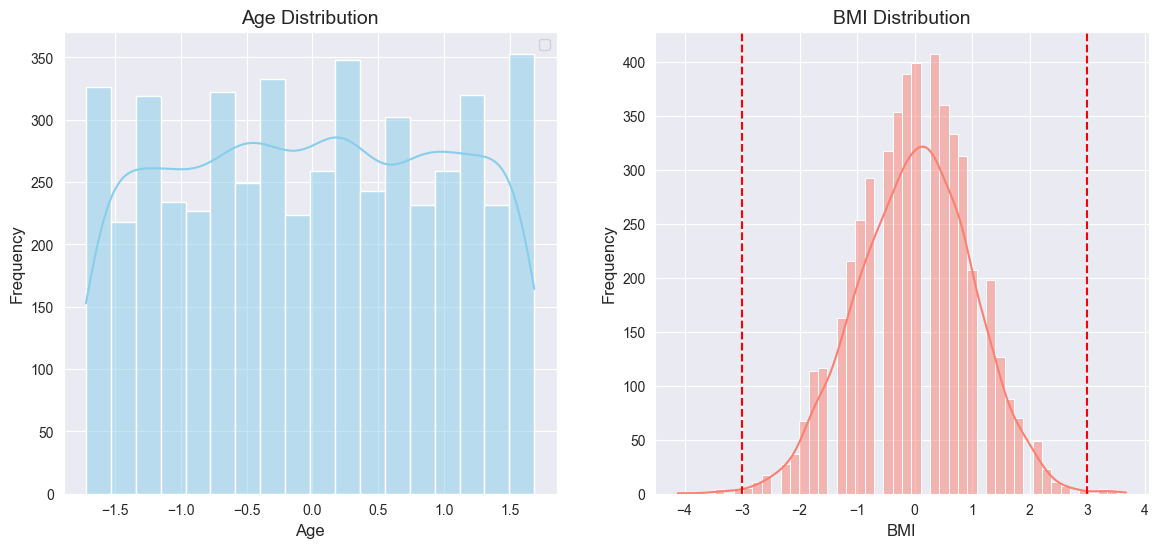

In [12]:
# plot distributions of age and bmi with z-scores
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# plot age z-score distribution 
sns.histplot(metadata['age_zscore'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Age Distribution', fontsize=14)
axes[0].set_xlabel('Age', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()  

# plot BMI z-score distribution
sns.histplot(metadata['bmi_zscore'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('BMI Distribution', fontsize=14)
axes[1].set_xlabel('BMI', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)    
axes[1].axvline(-3, color='red', linestyle='--', label='z=-3')
axes[1].axvline(3, color='red', linestyle='--', label='z=3')

In [14]:
z_threshold = 3

# Identify outliers before filtering
age_outliers = metadata.filter(pl.col('age_zscore').abs() > z_threshold)
bmi_outliers = metadata.filter(pl.col('bmi_zscore').abs() > z_threshold)
any_outliers = metadata.filter(
    (pl.col('age_zscore').abs() > z_threshold) | 
    (pl.col('bmi_zscore').abs() > z_threshold)
)

print(f"\nBEFORE FILTERING:")
print(f"  Total samples: {metadata.shape[0]}")
print(f"  Age outliers (|Z| > {z_threshold}): {age_outliers.shape[0]}")
print(f"  BMI outliers (|Z| > {z_threshold}): {bmi_outliers.shape[0]}")
print(f"  Any outliers: {any_outliers.shape[0]} ({(any_outliers.shape[0]/metadata.shape[0]*100):.2f}%)")

# Show outlier details if any found
if age_outliers.shape[0] > 0:
    print(f"\nAge outlier details:")
    print(age_outliers.select(['#SampleID', 'age', 'age_zscore', 'coffee_consumption']))

if bmi_outliers.shape[0] > 0:
    print(f"\nBMI outlier details:")
    print(bmi_outliers.select(['#SampleID', 'bmi', 'bmi_zscore', 'coffee_consumption']))

# Filter out outliers (keep only samples within Z-score threshold)
metadata_clean = metadata.filter(
    (pl.col('age_zscore').abs() <= z_threshold) & 
    (pl.col('bmi_zscore').abs() <= z_threshold)
)

print(f"\nAFTER FILTERING:")
print(f"  Clean samples: {metadata_clean.shape[0]}")
print(f"  Samples removed: {metadata.shape[0] - metadata_clean.shape[0]}")
print(f"  Retention rate: {(metadata_clean.shape[0]/metadata.shape[0]*100):.2f}%")

# Verify coffee group sizes after filtering
print(f"\nCoffee group sizes after outlier removal:")
coffee_counts_clean = metadata_clean['coffee_consumption'].value_counts().sort('coffee_consumption')
print(coffee_counts_clean)

# Check if all groups still have adequate sample sizes
min_group_size = coffee_counts_clean['count'].min()
print(f"\nMinimum group size after filtering: {min_group_size}")
if min_group_size >= 30:
    print("✅ All coffee groups maintain adequate sample sizes (≥30)")
else:
    print("⚠️  Some groups have small sample sizes (<30) after filtering")

# Update metadata to the clean version for downstream analysis
metadata = metadata_clean
print(f"\n✅ Outlier filtering complete. Using {metadata.shape[0]} clean samples for analysis.")


BEFORE FILTERING:
  Total samples: 5000
  Age outliers (|Z| > 3): 0
  BMI outliers (|Z| > 3): 19
  Any outliers: 19 (0.38%)

BMI outlier details:
shape: (19, 4)
┌──────────────┬─────┬────────────┬────────────────────┐
│ #SampleID    ┆ bmi ┆ bmi_zscore ┆ coffee_consumption │
│ ---          ┆ --- ┆ ---        ┆ ---                │
│ str          ┆ i64 ┆ f64        ┆ str                │
╞══════════════╪═════╪════════════╪════════════════════╡
│ Sample_00030 ┆ 4   ┆ -4.118704  ┆ occasional         │
│ Sample_00464 ┆ 41  ┆ 3.274016   ┆ occasional         │
│ Sample_00716 ┆ 9   ┆ -3.119688  ┆ daily              │
│ Sample_01709 ┆ 8   ┆ -3.319491  ┆ none               │
│ Sample_01775 ┆ 6   ┆ -3.719098  ┆ daily              │
│ …            ┆ …   ┆ …          ┆ …                  │
│ Sample_03146 ┆ 8   ┆ -3.319491  ┆ none               │
│ Sample_03545 ┆ 41  ┆ 3.274016   ┆ occasional         │
│ Sample_03691 ┆ 42  ┆ 3.473819   ┆ daily              │
│ Sample_04402 ┆ 7   ┆ -3.519295  ┆ none

### 3.3 Final Sample Filtering

In [15]:
# Final data alignment and validation
print("FINAL SAMPLE FILTERING AND ALIGNMENT")
print("=" * 50)

# Get sample IDs from clean metadata
clean_sample_ids = set(metadata['#SampleID'].to_list())
print(f"Clean metadata samples: {len(clean_sample_ids)}")

# Check feature table alignment
feature_sample_ids = set(feature_table.columns[1:])  # Skip first column (OTU IDs)
print(f"Feature table samples: {len(feature_sample_ids)}")

# Find common samples between metadata and feature table
common_samples = clean_sample_ids.intersection(feature_sample_ids)
print(f"Common samples: {len(common_samples)}")

# Samples only in metadata
only_metadata = clean_sample_ids - feature_sample_ids
print(f"Only in metadata: {len(only_metadata)}")

# Samples only in feature table  
only_feature_table = feature_sample_ids - clean_sample_ids
print(f"Only in feature table: {len(only_feature_table)}")

# Filter metadata to only include samples present in feature table
metadata_final = metadata.filter(pl.col('#SampleID').is_in(list(common_samples)))
print(f"\nFinal aligned metadata: {metadata_final.shape[0]} samples")

# Final coffee group sizes
print(f"\nFinal coffee group sizes:")
final_coffee_counts = metadata_final['coffee_consumption'].value_counts().sort('coffee_consumption')
print(final_coffee_counts)

# Verify all groups still have adequate sizes
min_final_size = final_coffee_counts['count'].min()
print(f"\nMinimum final group size: {min_final_size}")
if min_final_size >= 30:
    print("✅ All coffee groups maintain adequate sample sizes (≥30) for final analysis")
else:
    print("⚠️  Warning: Some groups have small sample sizes (<30) in final dataset")

# Update metadata to final version
metadata = metadata_final
print(f"\n✅ Final sample filtering complete. Ready for export: {metadata.shape[0]} samples")

FINAL SAMPLE FILTERING AND ALIGNMENT
Clean metadata samples: 4981
Feature table samples: 5000
Common samples: 4981
Only in metadata: 0
Only in feature table: 19

Final aligned metadata: 4981 samples

Final coffee group sizes:
shape: (3, 2)
┌────────────────────┬───────┐
│ coffee_consumption ┆ count │
│ ---                ┆ ---   │
│ str                ┆ u32   │
╞════════════════════╪═══════╡
│ daily              ┆ 1678  │
│ none               ┆ 1621  │
│ occasional         ┆ 1682  │
└────────────────────┴───────┘

Minimum final group size: 1621
✅ All coffee groups maintain adequate sample sizes (≥30) for final analysis

✅ Final sample filtering complete. Ready for export: 4981 samples


## 4. Export Clean Datasets

### 5.1 Metadata Export

### 5.2 Data Validation and Summary